## Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

# from importlib import reload

### define paths to data

In [2]:
curr_dir = os.getcwd()
os.path.abspath(os.path.join(curr_dir,'..','..'))

'/home/jefan/neurosketch'

In [3]:
## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths
data_dir = os.path.abspath(os.path.join(curr_dir,'..','..','data')) ## use relative paths 'D:\\data'
results_dir = os.path.join(proj_dir, 'csv')
nb_name = '2_object_evidence_during_drawing'

## add helpers to python path
import sys
if os.path.join(proj_dir, 'python') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'python'))

## module definitions
import analysis_helpers as h
reload(h)
h.data_dir = data_dir
h.path_to_recog = os.path.join(data_dir, 'features/recog')
h.path_to_draw = os.path.join(data_dir, 'features/drawing')
h.roi_list_draw = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'InsulaDraw', 'postCentralDraw',
                            'preCentralDraw', 'ParietalDraw', 'FrontalDraw', 'smgDraw'])
h.roi_list_recog = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
h.roi_list_recog_formatted = np.array(['V1', 'V2', 'LOC', 'FUS','PHC','IT','ENT','PRC','HC'])  #,'mOFC'])
roi_list_recog = h.roi_list_recog

### get file list

In [4]:
## get raw file list for recognition runs
path_to_recog = h.path_to_recog

RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] != 'Draw')])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] != 'Draw')])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [5]:
## get raw file list for drawing runs
path_to_draw = h.path_to_draw

DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] == 'Draw')])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] == 'Draw')])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [6]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
#print('Number of subs: {}'.format(len(sub_list)))

In [7]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

In [8]:
print 'We have data from {} subjects.'.format(len(sub_list))

We have data from 31 subjects.


### How well do we do at classifying the target when we train on recognition patterns only?

#### generate ALLDM supersubject matrix with classifier probabilities

In [ ]:
from IPython.display import clear_output
reload(h)
logged = [True,False]
versions = ['2way','3way','4wayIndependent','4way']

really_run = 0
if really_run:
    for l in logged:
        clear_output(wait=True)
        if l==True:
            tag = 'logged'
        elif l==False:
            tag = 'raw'
        for version in versions:
            ALLDM, Acc = h.make_drawing_predictions(sub_list,roi_list_recog,version=version,logged=l)
            ALLDM.to_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)),index=False) ## train recog, test drawing run    

#### basic summary plot of classifier accuracy between ROIs

In [9]:
version = '4way'
logged = True
ALLDM, Acc = h.make_drawing_predictions(sub_list,roi_list_recog,
                                        version=version,logged=logged)

Now analyzing hipp ...


In [17]:
x = x.assign(sub=sub_list)

In [18]:
D = pd.melt(D, 
            id_vars=['condition'], 
            var_name='roi',
            value_vars=roi_list_recog, 
            value_name='draw_acc')

,V1,V2,LOC,IT,fusiform,parahippo,PRC,ento,hipp,sub
0,0.271739,0.295652,0.328261,0.250000,0.272826,0.283696,0.217391,0.226087,0.279348,0110171
1,0.219565,0.216304,0.304348,0.218478,0.284783,0.259783,0.240217,0.272826,0.281522,0110172
2,0.233696,0.245652,0.258696,0.282609,0.252174,0.277174,0.283696,0.315217,0.220652,0111171
3,0.319565,0.305435,0.201087,0.268478,0.247826,0.263043,0.258696,0.191304,0.228261,0112171
4,0.220652,0.317391,0.300000,0.300000,0.276087,0.276087,0.280435,0.236957,0.235870,0112172
5,0.356522,0.392391,0.355435,0.315217,0.291304,0.254348,0.279348,0.245652,0.228261,0112173
6,0.352174,0.314130,0.319565,0.307609,0.307609,0.243478,0.223913,0.267391,0.272826,0113171
7,0.394565,0.422826,0.288043,0.306522,0.248913,0.269565,0.234783,0.284783,0.265217,0115174
8,0.317391,0.396739,0.266304,0.222826,0.235870,0.263043,0.289130,0.256522,0.270652,0117171
9,0.344565,0.259783,0.160870,0.247826,0.260870,0.254348,0.251087,0.258696,0.250000,0118171


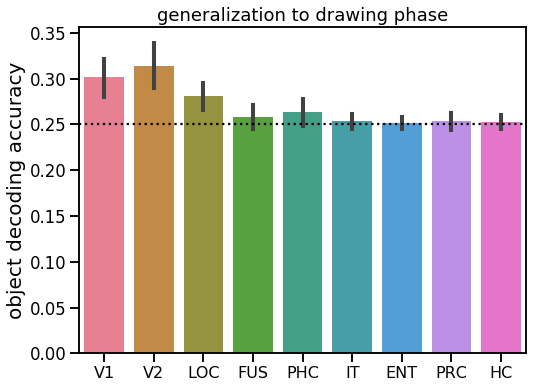

In [10]:
## plot test accuracy on drawing runs; trained on recognition runs
from matplotlib import rc
hfont = {'fontname':'Helvetica'}
if 'Acc' in locals():
    Acc = np.array(Acc)
    x = pd.DataFrame(Acc.transpose())
    x.columns = roi_list_recog    
    sns.set_context('talk')
    fig = plt.figure(figsize=(8,6))
    fig = sns.barplot(data=x,palette='husl',ci=95)
    
    fig2 = sns.stripplot(data=x,x="roi", 
                        y="prepost_diff", 
                        palette='husl')    

    chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5}
    plt.axhline(chance_dict[version],linestyle=':',color='k')
    plt.ylabel('object decoding accuracy',fontsize=20, **hfont)
    plt.title('generalization to drawing phase', **hfont)
    fig.set_xticklabels(h.roi_list_recog_formatted,fontsize=16, **hfont)
    out_path = os.path.join(proj_dir,'plots/{}/draw_decoding_accuracy.pdf'.format(nb_name))
    plt.savefig(out_path,format='pdf')

### make summary timecourse plots

In [ ]:
reload(h)
versions = ['2way','3way','4way', '4wayIndependent']
tags = ['logged', 'raw']
csvname = 'logistic_timeseries_drawing_neural_{}_{}.csv'

reallyRun = 0
if reallyRun:
    for version in versions:
        for tag in tags:
            ALLDM = pd.read_csv(
                os.path.join(results_dir, csvname.format(version,tag)))
            try:
                h.plot_summary_timecourse(ALLDM,
                                        this_iv='trial_num',
                                        roi_list=roi_list_recog,
                                        render_cond=1,
                                        version = version,
                                        proj_dir=proj_dir)
            except KeyError:
                pass

In [ ]:
vgg_mode = 0
if vgg_mode:
    vgg_tag = 'raw'
    baseline_correct = True
    bc = 'basecorr' if baseline_correct else ''
    VGG = pd.read_csv(str(results_dir)+'VGG_{}_{}.csv'.format(vgg_tag, bc))

    h.plot_summary_timecourse(VGG,
                            this_iv='trial_num',
                            roi_list=['VGG'],
                            render_cond=1,
                            baseline_correct = True,
                            version = version,
                            proj_dir=proj_dir)

#### get subject-level index of contrast between objects during drawing


In [ ]:
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
version_list = ['2way','3way','4way']
tag = 'logged'
this_iv = 'trial_num' ## other options 'run_num','trial_num','time_point'
reload(h)
for this_version in version_list:
    print '====== {} ======'.format(this_version)
    ALLDM = pd.read_csv('{}/csv/logistic_timeseries_drawing_neural_{}_{}.csv'.format(proj_dir,this_version,tag))
    ALLDM = h.cleanup_df(ALLDM)
    d = h.get_log_odds(ALLDM,
                   this_iv = this_iv,
                   roi_list = roi_list_recog,
                   version=this_version,
                   logged=True,
                   proj_dir=proj_dir)


In [ ]:
run_this = 1
if run_this:
    ## comparing 4-way and 2-way probability ratios
    d4way = pd.read_csv(os.path.join(proj_dir,'csv', 'difference_logprobs_4way.csv'))
    d2way = pd.read_csv(os.path.join(proj_dir,'csv', 'difference_logprobs_2way.csv'))
    inds = d4way['roi']=='V1'
    plt.scatter(d4way[inds]['target-foil'],d2way[inds]['target-foil'])

In [ ]:
conditions = ['target-foil','target-control','foil-control']
for condition in conditions:
    print('------- condition: {} -------'.format(condition))
    for this_roi in roi_list_recog:
        data = d[d['roi']==this_roi][condition].values
        U,lb,ub,p1,p2 = h.bootstrapCI(data,3000)
        print('ROI = {} | mean = {}  95% CI: [{} {}] p(x<0)={} p(x>0)={}'.format(
            this_roi,np.round(U,5),np.round(lb,3),np.round(ub,5),np.round(p1,5),np.round(p2,5)))

### How do individual differences in object evidence relate to individual differences in pre-post differentiation across ROIs?

In [ ]:
version = '4way'
tag = 'log'
d = pd.read_csv(os.path.join(proj_dir,'csv/difference_{}probs_{}.csv'.format(tag,version)))
prepost = pd.read_csv(os.path.join(proj_dir,'csv/neural_changes_by_surfroi_and_subject_longform.csv'))

In [ ]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp']
roi_dict = dict(zip(roi_list,prepost.roi.unique()))

for this_roi in roi_list:
    draw = d[d['roi']==this_roi]['target-foil'].values
    recog = (prepost[(prepost['condition']=='difference') & (prepost['roi']==roi_dict[this_roi])]['prepost_diff']).values

    
    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
    if np.round(p,5)<0.05:
        accent = '*'
    else:
        accent = ''
    print('ROI: {} r={}  p={} {}'.format(this_roi,np.round(r,5),np.round(p,5),accent))
    plt.xlabel('drawing: target vs. foil contrast') 
    plt.ylabel('recog: post-pre differentiation')
    if not os.path.exists(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name))):
        os.makedirs(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name)))
    plt.tight_layout()
    plt.savefig(os.path.join(proj_dir,'plots/{}/drawrecog/draw_recog_scatter_{}.png'.format(nb_name,this_roi)))
    plt.close(fig)

### How are individual differences in object evidence related between ROIs? 

In [ ]:
### jgunn will add correlation matrices here